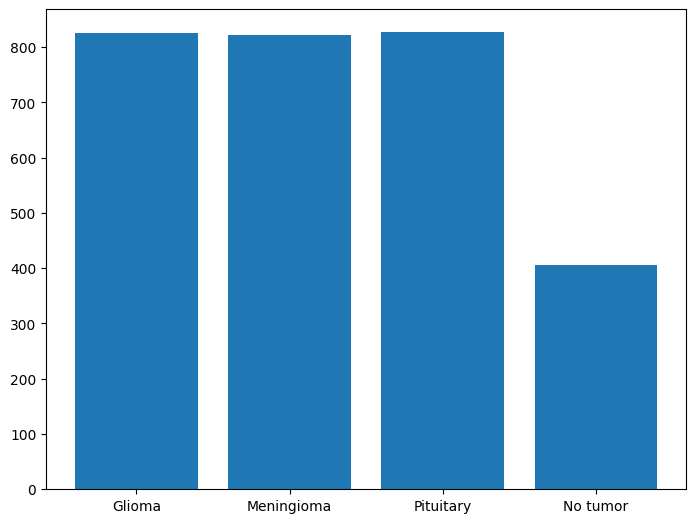

(2880, 2)
Found 2880 files belonging to 4 classes.
Found 394 files belonging to 4 classes.
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 407s 10s/step - accuracy: 0.3409 - balanced_sparse_categorical_accuracy: 0.3444 - loss: 24.7437 - val_accuracy: 0.6944 - val_balanced_sparse_categorical_accuracy: 0.6816 - val_loss: 0.7418
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7076 - balanced_sparse_categorical_accuracy: 0.6874 - loss: 0.7485 - val_accuracy: 0.6910 - val_balanced_sparse_categorical_accuracy: 0.6600 - val_loss: 0.6387
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.8005 - balanced_sparse_categorical_accuracy: 0.8066 - loss: 0.5241 - val_accuracy: 0.8819 - val_balanced_sparse_categorical_accuracy: 0.8900 - val_loss: 0.4086
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.8421 - balanced_sparse_categorical_accuracy: 0.8327 - loss: 0.3967 - val_accuracy: 0.8229 - val_balanced_sparse_categorical_accuracy: 0.7992 - val_loss: 0.4049
Epoch 5/2

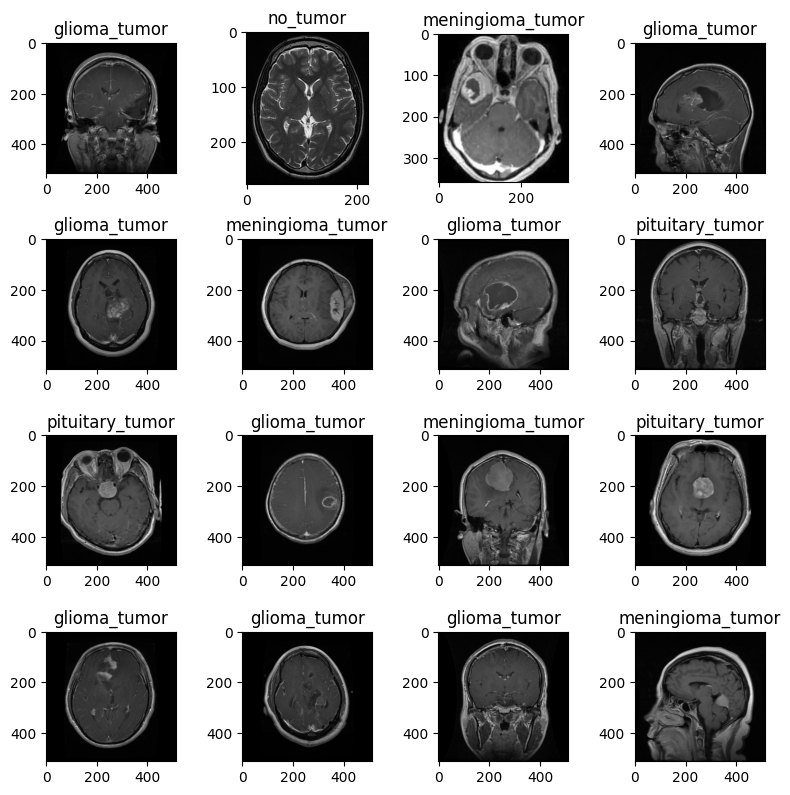

In [2]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the path to your data
path = Path("/content/drive/MyDrive/data/Training")

# List all JPEG images in the directory
img_as_jpg = list(path.glob(r"*/*.jpg"))

# Count the occurrences of each class
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_as_jpg))
glioma = file_count.count('glioma_tumor')
meningioma = file_count.count('meningioma_tumor')
no_tum = file_count.count('no_tumor')
pituitary = file_count.count('pituitary_tumor')

# Visualize the class distribution
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
labels = ['Glioma', 'Meningioma', 'Pituitary', 'No tumor']
count_train = [glioma, meningioma, pituitary, no_tum]
ax.bar(labels, count_train)
plt.show()

# Create a DataFrame with image paths and their labels
train = pd.concat([pd.Series(img_as_jpg, name="image").apply(str), pd.Series(file_count, name="type")], axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

# Display a grid of sample images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter + 1

# Define hyperparameters
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=4,
    batch_size=64,
)

# Load training and testing datasets
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/data/Training",
    image_size=hparams.image_size[:-1],
    batch_size=hparams.batch_size
)
ds1 = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/data/Testing",
    image_size=hparams.image_size[:-1],
    batch_size=hparams.batch_size
)

# Split the dataset into training and validation sets
train_split = round(0.8 * ds.cardinality().numpy())
train_ds = ds.take(train_split)
train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split)
validation_ds.class_names = ds.class_names

# Define distribution strategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

# Build and compile the model within the strategy scope
with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

# Train the model
model.fit(
    train_ds,
    epochs=20,
    validation_data=validation_ds
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


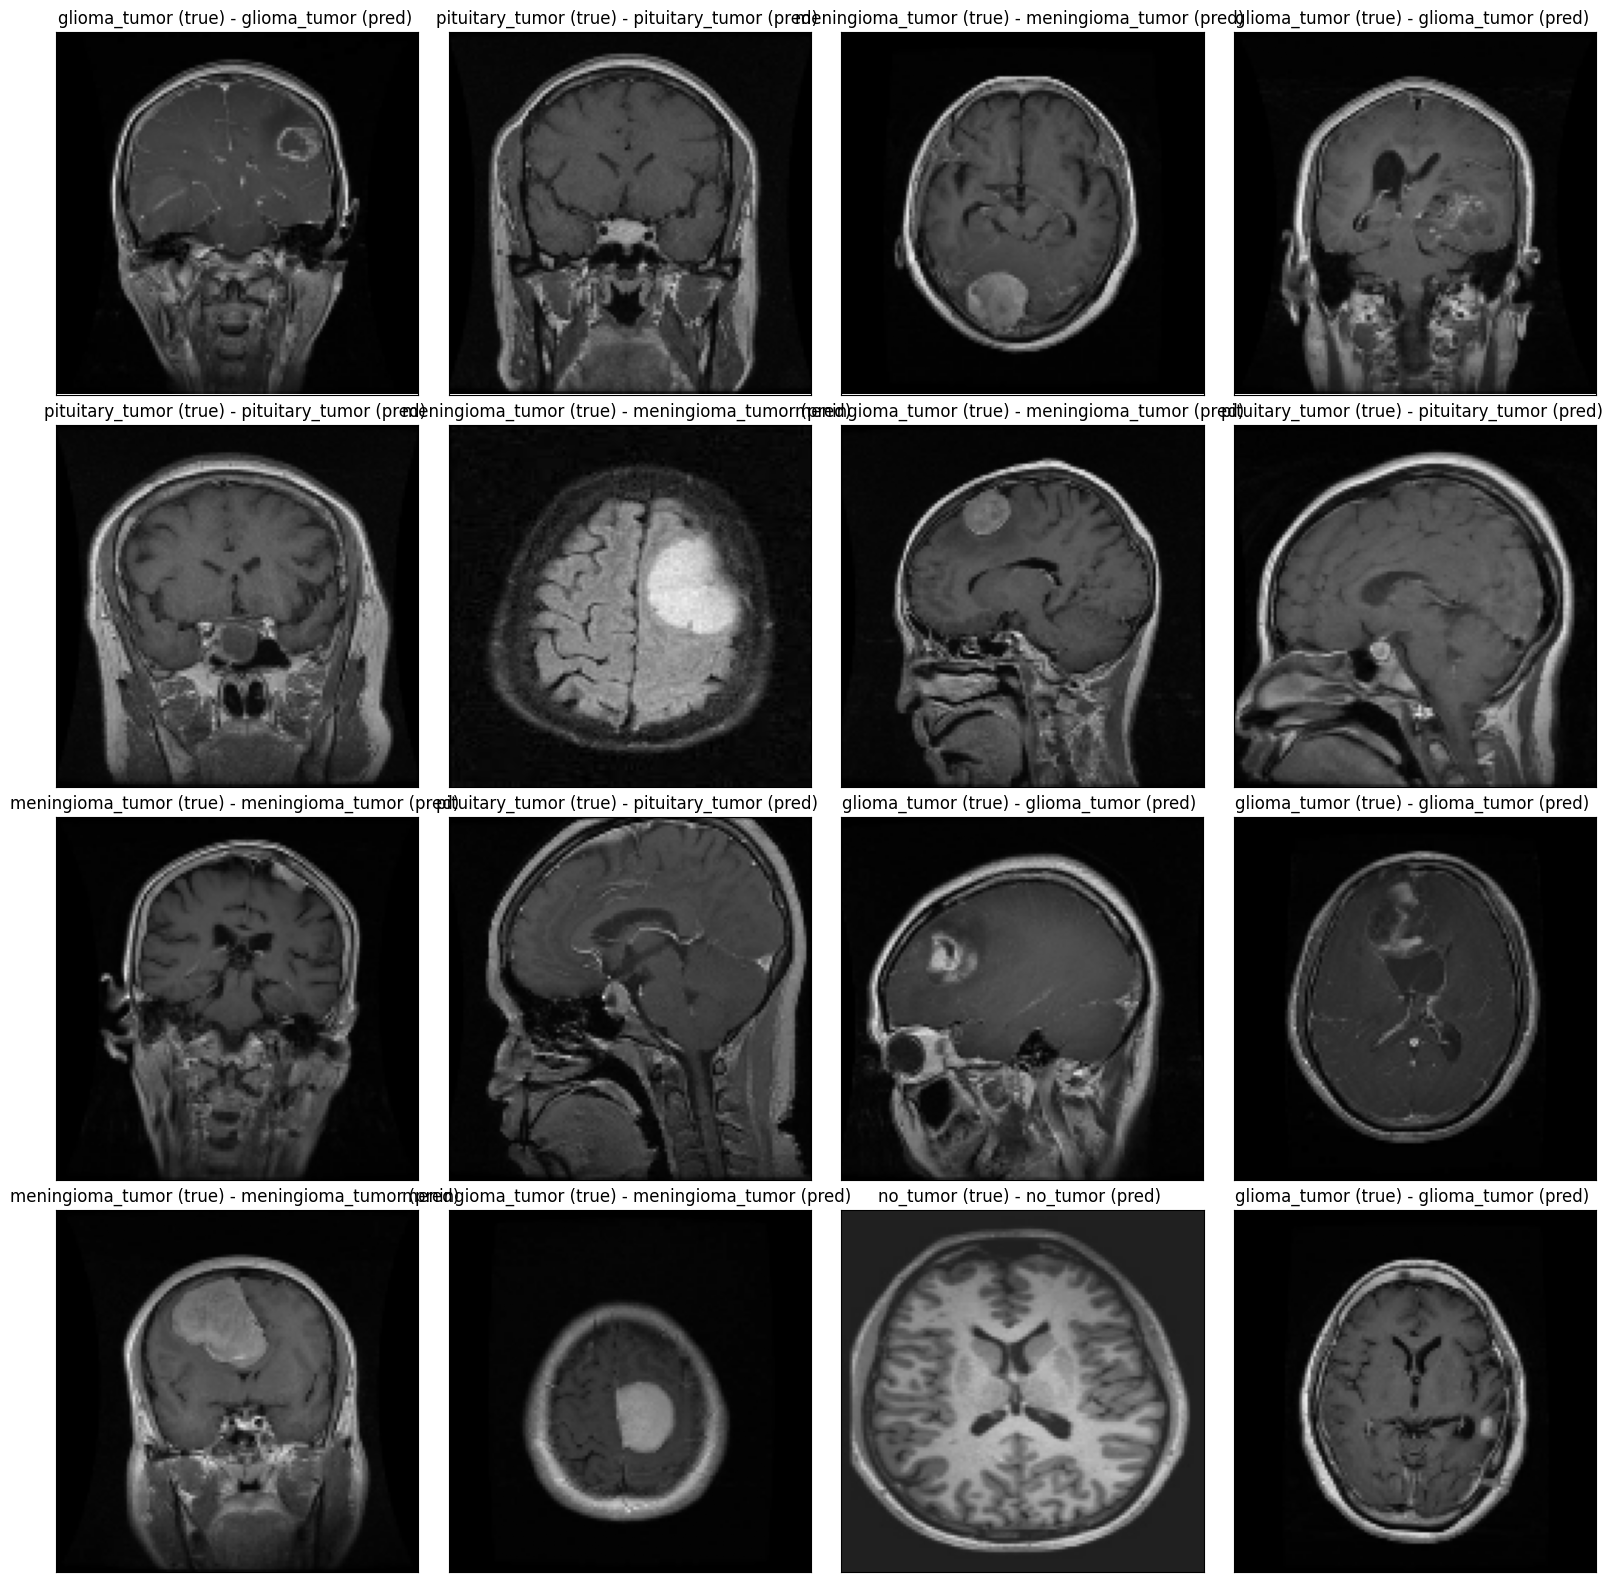

In [3]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [4]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

from sklearn.metrics import precision_score, recall_score


precision = precision_score(y_true, y_hat, average=None)


recall = recall_score(y_true, y_hat, average=None)

for i in range(len(precision)):
    print(f"Precision for class {i}: {precision[i]}")
    print(f"Recall for class {i}: {recall[i]}")

Precision for class 0: 0.9512195121951219
Recall for class 0: 0.9811320754716981
Precision for class 1: 0.9685534591194969
Recall for class 1: 0.9166666666666666
Precision for class 2: 0.9534883720930233
Recall for class 2: 0.9761904761904762
Precision for class 3: 0.9820359281437125
Recall for class 3: 0.9939393939393939


In [5]:
import os

# Ensure the directory exists
os.makedirs("models", exist_ok=True)


In [6]:
model.save("models/ViTenhanced_on_10_epochs.h5")


In [7]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")
model.save("models/ViT_on_10_epochs.keras")



Final accuracy on validation set : 0.967


In [8]:
!zip -r model.zip models/

  adding: models/ (stored 0%)
  adding: models/ViTenhanced_on_10_epochs.h5 (deflated 5%)
  adding: models/ViT_on_10_epochs.keras (deflated 5%)


In [9]:
!zip -r dataset.zip models/ViTenhanced_on_10_epochs.keras


	zip warning: name not matched: models/ViTenhanced_on_10_epochs.keras

zip error: Nothing to do! (try: zip -r dataset.zip . -i models/ViTenhanced_on_10_epochs.keras)


In [10]:
import tensorflow as tf
from PIL import Image
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display

# Define BalancedSparseCategoricalAccuracy class
class BalancedSparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_sparse_categorical_accuracy', **kwargs):
        super(BalancedSparseCategoricalAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        values = tf.equal(tf.cast(y_true, 'int32'), tf.cast(y_pred, 'int32'))
        values = tf.reduce_sum(tf.cast(values, 'float32'))
        self.total.assign_add(values)
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], 'float32'))

    def result(self):
        return self.total / self.count

# Define Patches layer
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({'patch_size': self.patch_size})
        return config

# Define PatchEncoder layer
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({
            'num_patches': self.num_patches,
            'projection_dim': self.projection.units
        })
        return config

# Define ViTClassfier model class
class ViTClassfier(tf.keras.Model):
    def __init__(self, input_shape, n_classes, patch_size=16, embedding_dim=64, n_heads=8, n_transformers=6,
                 transformer_units=128, transformer_dropout=0.1, mlp_units=256, mlp_dropout=0.1, **kwargs):
        super(ViTClassfier, self).__init__(**kwargs)
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.n_heads = n_heads
        self.n_transformers = n_transformers
        self.transformer_units = transformer_units
        self.transformer_dropout = transformer_dropout
        self.mlp_units = mlp_units
        self.mlp_dropout = mlp_dropout
        # Define layers here (replace with actual implementation)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(n_classes, activation='softmax')

    def call(self, inputs):
        # Forward pass through layers
        x = self.flatten(inputs)
        return self.dense(x)

    def get_config(self):
        config = {
            'input_shape': self.input_shape,
            'n_classes': self.n_classes,
            'patch_size': self.patch_size,
            'embedding_dim': self.embedding_dim,
            'n_heads': self.n_heads,
            'n_transformers': self.n_transformers,
            'transformer_units': self.transformer_units,
            'transformer_dropout': self.transformer_dropout,
            'mlp_units': self.mlp_units,
            'mlp_dropout': self.mlp_dropout
        }
        base_config = super().get_config()
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        return cls(
            input_shape=config['input_shape'],
            n_classes=config['n_classes'],
            patch_size=config['patch_size'],
            embedding_dim=config['embedding_dim'],
            n_heads=config['n_heads'],
            n_transformers=config['n_transformers'],
            transformer_units=config['transformer_units'],
            transformer_dropout=config['transformer_dropout'],
            mlp_units=config['mlp_units'],
            mlp_dropout=config['mlp_dropout']
        )

# Instantiate and compile the model
input_shape = (128, 128, 3)  # Example input shape
n_classes = 4  # Number of output classes
model = ViTClassfier(input_shape=input_shape, n_classes=n_classes)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[BalancedSparseCategoricalAccuracy()])

# Save the model in .keras format
model.save('/content/drive/MyDrive/models/ViTenhanced_on_10_epochs.keras')

# Load the model using custom_object_scope
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({
    'BalancedSparseCategoricalAccuracy': BalancedSparseCategoricalAccuracy,
    'ViTClassfier': ViTClassfier,
    'Patches': Patches,
    'PatchEncoder': PatchEncoder
}):
    model = tf.keras.models.load_model('/content/drive/MyDrive/models/ViTenhanced_on_10_epochs.keras')

# Define image preprocessing function
def preprocess_image(img):
    img = img.resize((128, 128))  # Resize the image to the required input size
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Define prediction function
def predict_label(img):
    img_array = preprocess_image(img)
    prediction = model.predict(img_array)
    predicted_label = tf.argmax(prediction, axis=1)[0].numpy()
    return predicted_label

# Define file upload handler
def handle_file_upload(change):
    uploaded_file = file_upload.value
    if uploaded_file:
        content = uploaded_file[list(uploaded_file.keys())[0]]['content']
        img = Image.open(BytesIO(content))
        predicted_label = predict_label(img)
        print("Predicted label:", predicted_label)
        print("Where:\n1. Glioma\n2. Meningioma\n3. No Tumor\n4. Pituitary Tumor")

# Create and display file upload widget
file_upload = widgets.FileUpload(description="Upload Image")
file_upload.observe(handle_file_upload, names='value')

display(file_upload)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


FileUpload(value={}, description='Upload Image')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted label: 2
Where:
1. Glioma
2. Meningioma
3. No Tumor
4. Pituitary Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label: 2
Where:
1. Glioma
2. Meningioma
3. No Tumor
4. Pituitary Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted label: 3
Where:
1. Glioma
2. Meningioma
3. No Tumor
4. Pituitary Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label: 2
Where:
1. Glioma
2. Meningioma
3. No Tumor
4. Pituitary Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label: 2
Where:
1. Glioma
2. Meningioma
3. No Tumor
4. Pituitary Tumor


In [11]:
# Save the model with updated configuration handling
model.save('/content/drive/MyDrive/models/ViTenhanced_on_10_epochs.keras')


In [12]:
display(file_upload)

FileUpload(value={'image(1).jpg': {'metadata': {'name': 'image(1).jpg', 'type': 'image/jpeg', 'size': 43670, '…